# Bincentive 交易室實習生 Python 測驗
## 陳韋勳

### Content
* 1. 爬取資料
* 2. 建立簡易投組並計算數據
* 3. 定期進行資產再平衡
* 4. 資料上傳Google Sheet

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import datetime 
import pandas_datareader as web
import quantstats as qs

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. 爬取資料
### 利用web.DataReader從Yahoo Finance網站爬下BTC/USDT、ETH/USDT、BNB/USDT 日線資料 (2020/1/1-2020/4/23)<br>  並取三商品的Close整理成一張dataframe

In [2]:
# 下載股價資料
BTCdata= web.DataReader(name='BTC-USD', data_source='yahoo', start='2020-01-02', end='2020-04-24')
ETHdata= web.DataReader(name='ETH-USD', data_source='yahoo', start='2020-01-02', end='2020-04-24')
BNBdata= web.DataReader(name='BNB-USD', data_source='yahoo', start='2020-01-02', end='2020-04-24')

# 建立一df用來放置三商品的Close
df=pd.DataFrame([])
df['BTC']=BTCdata['Close']
df['ETH']=ETHdata['Close']
df['BNB']=BNBdata['Close']
df.index =  pd.to_datetime(df.index, format='%Y-%m-%d')
df

,BTC,ETH,BNB
Date,,,
2020-01-01,7200.174316,130.802002,13.689083
2020-01-02,6985.470215,127.410179,13.027011
2020-01-03,7344.884277,134.171707,13.660452
2020-01-04,7410.656738,135.069366,13.891512
2020-01-05,7411.317383,136.276779,14.111019
...,...,...,...
2020-04-19,6881.958496,172.297165,15.085403
2020-04-20,6880.323242,172.737701,15.205772
2020-04-21,7117.207520,182.599579,15.693160


## 2. 建立簡易投組並計算數據
### 以 BTC:ETH:BNB = 4:4:2 的方式組成一資產投組 (假設本金100萬USDT)，繪製其權益曲線，並計算出 Calmar Ratio、Sharpe Ratio 及 MaxDrawdown

$ Solution: $
$$ Y_t = [ \frac {V_{1,  t,close}}{V_{1,t-1,close}}, \frac {V_{2,t,close}}{V_{2,t-1,close}}, \frac {V_{3,t,close}}{V_{3,t-1,close}}   ] $$

$$ W_t = [w_0, w_1,w_2] $$

$$ P_t = \prod^T_{t=1} Y_t \cdot W_{t-1} $$
$$ 以下有有一df叫pct代表Y，一df叫weight代表W，有一df叫profit代表P $$

In [3]:
pct=df.pct_change()+1
pct.head()

,BTC,ETH,BNB
Date,,,
2020-01-01,NaN,NaN,NaN
2020-01-02,0.970181,0.974069,0.951635
2020-01-03,1.051452,1.053069,1.048625
2020-01-04,1.008955,1.006690,1.016915
2020-01-05,1.000089,1.008939,1.015802


In [4]:
#回傳需要重配置的日子，freq代表重配置的頻率，ex:none買進持有, day每日更新, month每月出更新, quarter每季更新

def rebalanceList(freq):
    stime= datetime.date(2020,1,1)
    etime= datetime.date(2020,4,23)

    year = stime.year
    smonth=stime.month
    emonth=etime.month
    rebalanceD=[]

    if freq=='none':
        tempstr=str(year)+'-'+str(smonth)+'-'+str(1)
        rebalanceD.append(pd.to_datetime(tempstr))
        return rebalanceD
    elif freq== 'day':
        return 'day'
    elif freq=='month':
        for m in range(smonth, emonth+1):
            tempstr=str(year)+'-'+str(m)+'-'+str(1)
            rebalanceD.append(pd.to_datetime(tempstr))
        return rebalanceD
    elif freq== 'quarter':
        for m in range(smonth, emonth+1,3):
            tempstr=str(year)+'-'+str(m)+'-'+str(1)
            rebalanceD.append(pd.to_datetime(tempstr))
        return rebalanceD
    
#回傳一df叫weight,裡面放置每日每一商品的持有比例
def calweight(freq):
    weight=pd.DataFrame([])
    weight=pct.copy()
    
    for index,row in weight.iterrows():
        a=rebalanceList(freq)
        if a=='day':
            weight['BTC']=0.4
            weight['ETH']=0.4
            weight['BNB']=0.2
            break
        elif index in a:
            weight.loc[index,'BTC']=0.4
            weight.loc[index,'ETH']=0.4
            weight.loc[index,'BNB']=0.2
            btcPweight=row['BTC']
            ethPweight=row['ETH']
            bnbPweight=row['BNB']
        else:
            total=row['BTC']*btcPweight+row['ETH']*ethPweight+row['BNB']*bnbPweight
            weight.loc[index,'BTC']=row['BTC']*btcPweight/total
            weight.loc[index,'ETH']=row['ETH']*ethPweight/total
            weight.loc[index,'BNB']=row['BNB']*bnbPweight/total
            btcPweight=row['BTC']
            ethPweight=row['ETH']
            bnbPweight=row['BNB']
    return weight

# 回傳一df叫profit裡面放置每日每一商品的報酬率(報酬率*持有比例)
# 加總即得當日投組報酬率(rr)，投組報酬率連乘即得目前投組報酬率(totalrr)
def calprofit(weight,freq):
    b=rebalanceList(freq)
    if b=='day':
        w=[0.4,0.4,0.2]
        profit=w*pct
    else:
        profit=(weight.shift(1))*pct
    profit['rr']=profit['BTC']+profit['ETH']+profit['BNB']
    profit['totalrr']=profit['rr'].cumprod()
    return profit

def cal(freq):
    weight=calweight(freq)
    profit=calprofit(weight,freq)
    print(rebalanceList(freq))
    return weight,profit
weight,profit =cal('none')

[Timestamp('2020-01-01 00:00:00')]


Calmar Ratio: 2.0678414647335144
Sharpe Ratio: 1.11224482904464
Max Drawdown: -0.5871587478760049


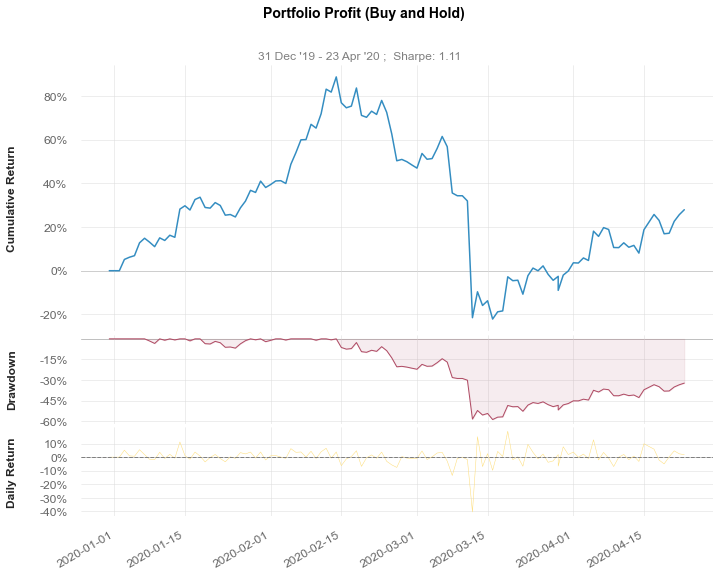

In [5]:
qs.extend_pandas()
print('Calmar Ratio:', qs.stats.calmar(profit['totalrr']))
print('Sharpe Ratio:', qs.stats.sharpe(profit['totalrr']))
print('Max Drawdown:', qs.stats.max_drawdown(profit['totalrr']))
qs.plots.snapshot(profit['totalrr'], title='Portfolio Profit (Buy and Hold)')

## 3. 定期進行資產再平衡
### 請投組依照每日、每月、每季的方式以 BTC:ETH:BNB = 4:4:2 的比例進行資產再平衡(Rebalance)
### 由於買進持有後，資產價格每天都會變動，導致投組價值變動，其中資產的比例也會變動。再平衡的目的即是將資產比例重新調整至原始的比例，而每日、每月、每季調整的差別在於調整的日期、頻率不同

day
Calmar Ratio: 2.0709500130352247
Sharpe Ratio: 1.108676041649992
Max Drawdown: -0.57995442107976


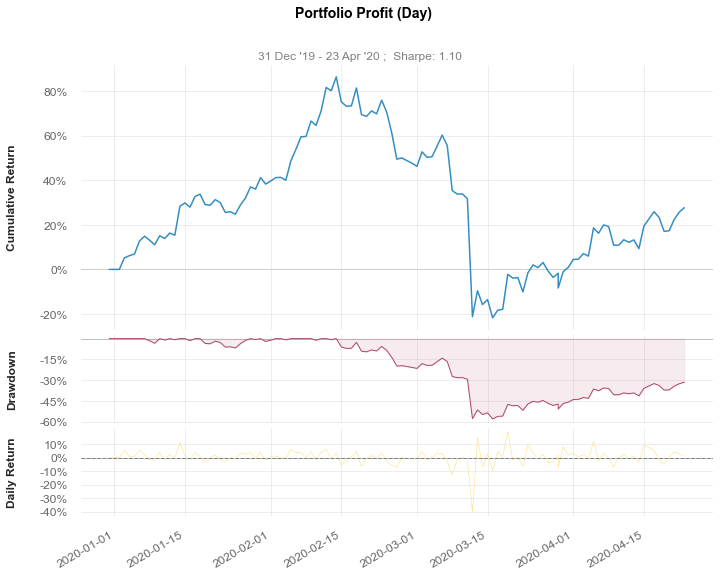

In [6]:
#每日資產再平衡
weight1,profit1= cal('day')
print('Calmar Ratio:', qs.stats.calmar(profit1['totalrr']))
print('Sharpe Ratio:', qs.stats.sharpe(profit1['totalrr']))
print('Max Drawdown:', qs.stats.max_drawdown(profit1['totalrr']))
qs.plots.snapshot(profit1['totalrr'], title='Portfolio Profit (Day)')


[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-02-01 00:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-01 00:00:00')]
Calmar Ratio: 2.074009057453882
Sharpe Ratio: 1.1106294201381237
Max Drawdown: -0.5827961363141267


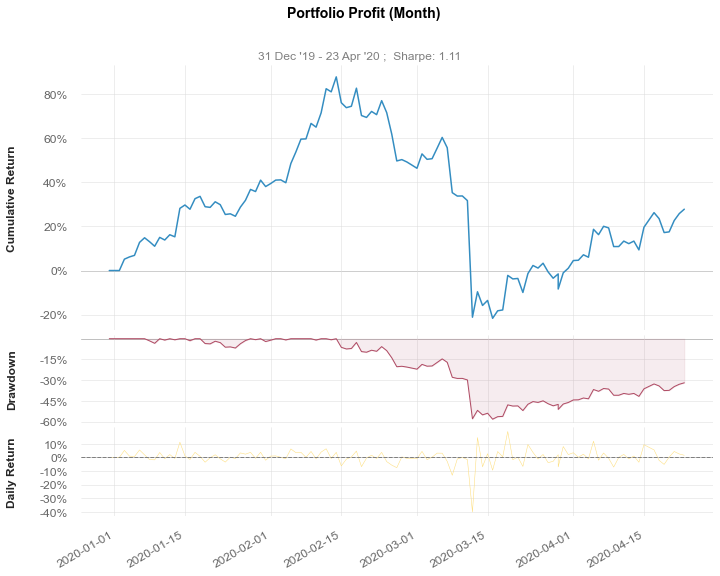

In [7]:
#每月資產再平衡
weight2,profit2= cal('month')
print('Calmar Ratio:', qs.stats.calmar(profit2['totalrr']))
print('Sharpe Ratio:', qs.stats.sharpe(profit2['totalrr']))
print('Max Drawdown:', qs.stats.max_drawdown(profit2['totalrr']))
qs.plots.snapshot(profit2['totalrr'], title='Portfolio Profit (Month)')

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-04-01 00:00:00')]
Calmar Ratio: 1.9537107654236494
Sharpe Ratio: 1.0911126252075158
Max Drawdown: -0.5871587478760049


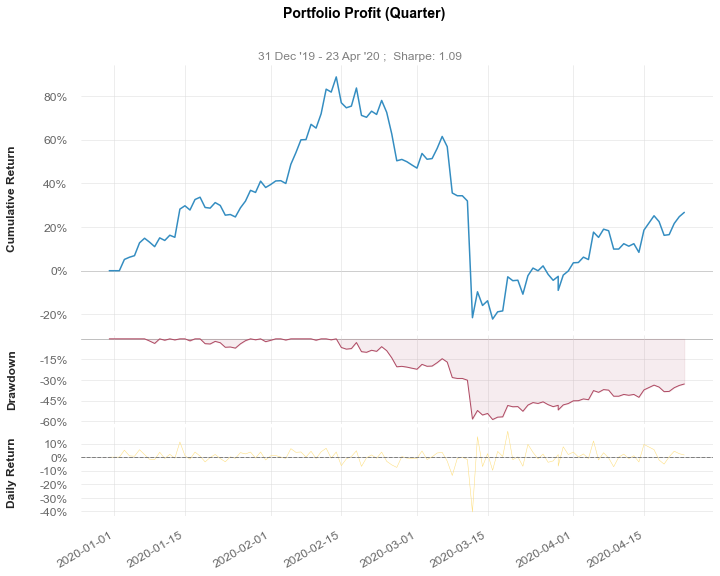

In [8]:
#每季資產再平衡
weight3,profit3= cal('quarter')
print('Calmar Ratio:', qs.stats.calmar(profit3['totalrr']))
print('Sharpe Ratio:', qs.stats.sharpe(profit3['totalrr']))
print('Max Drawdown:', qs.stats.max_drawdown(profit3['totalrr']))
qs.plots.snapshot(profit3['totalrr'], title='Portfolio Profit (Quarter)')

## 4. 資料上傳Google Sheet
### 將每日投組資料(當日權益、各資產比重、報酬)上傳至 Google Sheet 或資料庫

In [9]:
import pygsheets
gc = pygsheets.authorize(service_account_file='key.json')
survey_url = 'https://docs.google.com/spreadsheets/d/12iUXAo-RCPvUYRTWQag3KAvf5cjZX6rQiO_KVOt9m8U/edit#gid=0'
sh = gc.open_by_url(survey_url)
wks = sh.worksheet_by_title("Sheet1")

report=pd.DataFrame([])
report['Total Profit ($)']=profit1['totalrr']*1000000
report['Daily Profit ($)']=profit1['totalrr']*1000000
report['BTCweight']=weight1['BTC']
report['ETHweight']=weight1['ETH']
report['BNBweight']=weight1['BNB']
report['BTC_daily_rateofreturn']=profit1['BTC']
report['ETH_daily_rateofreturn']=profit1['ETH']
report['BNB_daily_rateofreturn']=profit1['BNB']

wks.set_dataframe(report, start='A1',copy_index=True )
wks.update_value('B2', '1000000')
wks.update_value('C2', '0')
report.loc['2020-01-01','Total Profit ($)']=1000000
report.head()

,Total Profit ($),Daily Profit ($),BTCweight,ETHweight,BNBweight,BTC_daily_rateofreturn,ETH_daily_rateofreturn,BNB_daily_rateofreturn
Date,,,,,,,,
2020-01-01,1.000000e+06,NaN,0.4,0.4,0.2,NaN,NaN,NaN
2020-01-02,9.680269e+05,9.680269e+05,0.4,0.4,0.2,0.388072,0.389628,0.190327
2020-01-03,1.017913e+06,1.017913e+06,0.4,0.4,0.2,0.420581,0.421228,0.209725
2020-01-04,1.027726e+06,1.027726e+06,0.4,0.4,0.2,0.403582,0.402676,0.203383
2020-01-05,1.034686e+06,1.034686e+06,0.4,0.4,0.2,0.400036,0.403576,0.203160


Text(0.5, 1.0, 'Portfolio Profit with Different Rebalaning Frequency')

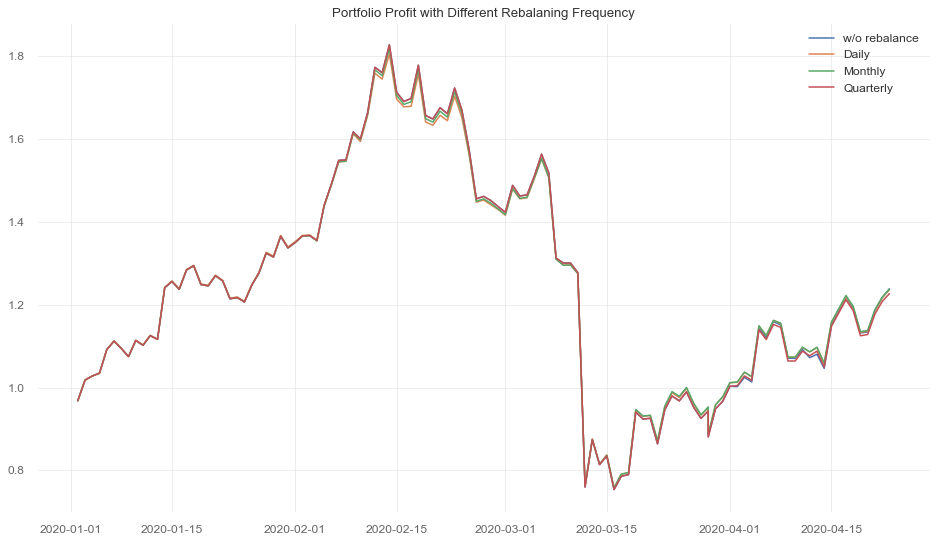

In [23]:
plt.figure(figsize=(16,9))
plt.plot(profit['totalrr'], label='w/o rebalance')
plt.plot(profit1['totalrr'], label='Daily')
plt.plot(profit2['totalrr'], label='Monthly')
plt.plot(profit3['totalrr'], label= 'Quarterly')
plt.legend()
plt.title('Portfolio Profit with Different Rebalaning Frequency')